In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.stats import shapiro
# import nplinalg least squares
import scipy.stats as stats
import statsmodels.api as sm
import scipy
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import pickle 
from typing import Callable, Any, Iterable

In [2]:
print(pd. __version__)

2.2.1


In [3]:
print(sns.__version__)

0.13.2


In [4]:
pd.options.mode.chained_assignment = None

In [5]:
pd.options.mode.copy_on_write = False

### STOCKS

In [6]:
df_tickers = pd.read_csv('data/SPY holdings.csv')

In [7]:
df_tickers.head()

,Ticker,sector,sectorKey,industry,beta,marketCap
0,MSFT,Technology,technology,Software - Infrastructure,0.890,3.094184e+12
1,AAPL,Technology,technology,Consumer Electronics,1.289,2.665581e+12
2,NVDA,Technology,technology,Semiconductors,1.725,2.195913e+12
3,AMZN,Consumer Cyclical,consumer-cyclical,Internet Retail,1.171,1.811770e+12
4,META,Communication Services,communication-services,Internet Content & Information,1.208,1.234169e+12


In [8]:
len(df_tickers)

504

In [9]:
tickers = list(df_tickers['Ticker'])

In [13]:
%%time
# tickers.remove('QRVO')
data = yf.download("SPY", period='15y', interval='1wk')[['Adj Close']]
data.rename(columns={'Adj Close': "SPY"}, inplace=True)

tickers_with_errors = []
for ticker in tickers:
    data_ticker = yf.download(ticker, period='15y', interval='1wk')
    if not data_ticker.empty:
        data_ticker = data_ticker[["Adj Close"]]
        data_ticker.rename(columns={'Adj Close': ticker}, inplace=True)
        data = data.join(data_ticker, how='left')
    else:
        tickers_with_errors.append(ticker)
        print('Error, no data for the ticker: ', ticker)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')


Error, no data for the ticker:  BRK.B


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Error, no data for the ticker:  -


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Error, no data for the ticker:  BF.B


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

CPU times: user 6.45 s, sys: 991 ms, total: 7.44 s
Wall time: 1min 47s


In [14]:
print(tickers_with_errors) # tickers with errors

['BRK.B', '-', 'BF.B']


In [15]:
data.columns[data.isna().sum() > len(data) - 100].tolist() # columns to drop

['KVUE', 'GEHC', 'VLTO', 'QRVO']

In [16]:
data = data.drop(columns=data.columns[data.isna().sum() > len(data) - 100].tolist()) # dropping columns

In [17]:
data.head()

,SPY,MSFT,AAPL,NVDA,AMZN,META,GOOGL,GOOG,LLY,AVGO,...,FMC,HAS,PARA,WHR,DVA,ZION,MHK,VFC,FOX,NWS
Date,,,,,,,,,,,,,,,,,,,,,
2009-03-30,63.570396,13.965046,3.507038,2.595965,3.9085,NaN,9.253754,NaN,21.001789,NaN,...,16.956327,16.788895,3.730278,22.674856,22.299999,8.821772,34.250000,10.028198,NaN,NaN
2009-04-06,64.739738,14.650264,3.615283,2.761081,3.9885,NaN,9.321822,NaN,20.766382,NaN,...,16.959846,16.864239,4.122535,22.687702,22.620001,9.692191,32.720001,10.291479,NaN,NaN
2009-04-13,65.697968,14.300206,3.731689,2.696869,3.9025,NaN,9.815816,NaN,21.472589,NaN,...,16.238377,17.523481,5.153166,24.402777,21.575001,11.778051,36.790001,10.336663,NaN,NaN
2009-04-20,65.381088,15.573823,3.746203,2.621191,4.2230,NaN,9.746997,NaN,21.001789,NaN,...,16.231340,17.423023,4.783984,26.162800,21.855000,9.472629,49.000000,10.737039,NaN,NaN
2009-04-27,66.309044,15.074804,3.847190,2.676229,3.9480,NaN,9.852102,NaN,21.307182,NaN,...,17.280113,16.857965,5.530039,29.464466,22.945000,8.398329,46.290001,9.199392,NaN,NaN


In [18]:
data.isna().sum()[data.isna().sum() > 0]

META    163
GOOG    260
AVGO     18
TSLA     65
ABBV    196
       ... 
GNRC     45
NCLH    198
FOXA    519
FOX     519
NWS     220
Length: 66, dtype: int64

In [19]:
data.isna().sum().sum()

16989

In [20]:
tickers = list(data.columns)
# tickers.remove('SPY')

In [21]:
data[['Return ' + ticker for ticker in tickers]] = np.log(data[tickers]).diff()
data = data.drop(columns = tickers)
data.head()

/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_18542/890682338.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[['Return ' + ticker for ticker in tickers]] = np.log(data[tickers]).diff()
/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_18542/890682338.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[['Return ' + ticker for ticker in tickers]] = np.log(data[tickers]).diff()
/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_18542/890682338.py:1: PerformanceWarning: DataFrame is highly

,Return SPY,Return MSFT,Return AAPL,Return NVDA,Return AMZN,Return META,Return GOOGL,Return GOOG,Return LLY,Return AVGO,...,Return FMC,Return HAS,Return PARA,Return WHR,Return DVA,Return ZION,Return MHK,Return VFC,Return FOX,Return NWS
Date,,,,,,,,,,,,,,,,,,,,,
2009-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-06,0.018227,0.047901,0.030398,0.061664,0.020262,NaN,0.007329,NaN,-0.011272,NaN,...,0.000208,0.004478,0.099986,0.000566,0.014248,0.094098,-0.045700,0.025915,NaN,NaN
2009-04-13,0.014693,-0.024184,0.031691,-0.023531,-0.021798,NaN,0.051637,NaN,0.033442,NaN,...,-0.043471,0.038346,0.223143,0.072874,-0.047299,0.194917,0.117240,0.004381,NaN,NaN
2009-04-20,-0.004835,0.085318,0.003882,-0.028462,0.078928,NaN,-0.007036,NaN,-0.022170,NaN,...,-0.000433,-0.005749,-0.074338,0.069642,0.012894,-0.217831,0.286594,0.038002,NaN,NaN
2009-04-27,0.014093,-0.032567,0.026600,0.020780,-0.067337,NaN,0.010726,NaN,0.014437,NaN,...,0.062612,-0.032969,0.144921,0.118846,0.048670,-0.120374,-0.056894,-0.154562,NaN,NaN


In [22]:
data = data.reset_index()

### Regressions

In [23]:
data.head()

,Date,Return SPY,Return MSFT,Return AAPL,Return NVDA,Return AMZN,Return META,Return GOOGL,Return GOOG,Return LLY,...,Return FMC,Return HAS,Return PARA,Return WHR,Return DVA,Return ZION,Return MHK,Return VFC,Return FOX,Return NWS
0,2009-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-04-06,0.018227,0.047901,0.030398,0.061664,0.020262,NaN,0.007329,NaN,-0.011272,...,0.000208,0.004478,0.099986,0.000566,0.014248,0.094098,-0.045700,0.025915,NaN,NaN
2,2009-04-13,0.014693,-0.024184,0.031691,-0.023531,-0.021798,NaN,0.051637,NaN,0.033442,...,-0.043471,0.038346,0.223143,0.072874,-0.047299,0.194917,0.117240,0.004381,NaN,NaN
3,2009-04-20,-0.004835,0.085318,0.003882,-0.028462,0.078928,NaN,-0.007036,NaN,-0.022170,...,-0.000433,-0.005749,-0.074338,0.069642,0.012894,-0.217831,0.286594,0.038002,NaN,NaN
4,2009-04-27,0.014093,-0.032567,0.026600,0.020780,-0.067337,NaN,0.010726,NaN,0.014437,...,0.062612,-0.032969,0.144921,0.118846,0.048670,-0.120374,-0.056894,-0.154562,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,2024-02-26,0.009797,0.012497,-0.015794,0.042987,0.018290,0.038111,-0.048533,-0.050898,0.016215,...,0.089950,0.013221,-0.023467,-0.034507,0.013165,-0.006684,0.054763,0.016139,-0.025244,-0.006548
779,2024-03-04,-0.002206,-0.022588,-0.050983,0.061843,-0.016235,0.007240,-0.012695,-0.013048,-0.025878,...,0.089727,0.029414,-0.001828,0.039712,0.062976,0.085721,0.002057,-0.008658,-0.025137,-0.001827
780,2024-03-11,-0.003700,0.024800,0.011009,0.003571,-0.005318,-0.044146,0.041728,0.042239,-0.010513,...,0.036954,0.029700,0.025295,-0.039268,0.010890,-0.059752,-0.031987,-0.079935,0.031259,-0.033838
781,2024-03-18,0.025178,0.029156,-0.001972,0.070882,0.025193,0.051295,0.065720,0.065343,0.021565,...,-0.042232,0.028296,0.007852,0.052895,-0.018763,0.021383,0.060030,-0.047810,0.015865,0.017179


In [26]:
def instrumental_variables(data, tickers, step='vanilla', iv_column_name='Return SPY', coefficients_iv_train=None):

    coefficients = dict.fromkeys(tickers)
    intercepts = dict.fromkeys(tickers)
    predictions = dict.fromkeys(tickers)
    predictions_reg = dict.fromkeys(tickers)
    predictions_historical_mean = dict.fromkeys(tickers)
    
    errors = dict.fromkeys(tickers)
    errors_reg = dict.fromkeys(tickers)
    errors_historical_mean = dict.fromkeys(tickers)
    
    MSE = dict.fromkeys(tickers)
    MSE_reg = dict.fromkeys(tickers)
    MSE_historical_mean = dict.fromkeys(tickers)
    
    for ticker in tqdm(tickers):
        if step == 'vanilla':
            column_x = 'Return ' + ticker
            column_y = 'Return ' + ticker    
        elif step == 'iv_train':
            column_x = iv_column_name
            column_y = 'Return ' + ticker
        elif step == 'iv_pred_v1':
            column_x = 'Return ' + ticker + ' cap'
            column_y = 'Return ' + ticker  
        elif step == 'iv_pred_v2':
            column_x = 'Return ' + ticker 
            column_y = 'Return ' + ticker  
            
        coefficients[ticker] = []
        intercepts[ticker] = []
        predictions[ticker] = []
        predictions_reg[ticker] = [] 
        predictions_historical_mean[ticker] = []
        
        errors[ticker] = []
        errors_reg[ticker] = []
        errors_historical_mean[ticker] = []
        
        if step == 'iv_pred_v1':
            start_idx = min(data[~data['Return ' + ticker + ' cap'].isna()][['Return ' + ticker + ' cap']].index)
        else:
            start_idx = min(data[~data['Return ' + ticker].isna()][['Return ' + ticker]].index)

        start_pred_idx = start_idx + 50
        idx = start_pred_idx
        idx_coefficients = 0

        while idx < len(data):
            x = [np.mean(data[column_x].iloc[start_idx:idx-1])] + list(data[column_x].iloc[start_idx:idx-1])
            y = data[column_y].iloc[start_idx:idx]
            x_test = data[column_x].iloc[idx-1]
            y_test = data[column_y].iloc[idx]
            if step == 'iv_pred_v2':
                b = coefficients_iv_train[ticker]['Coefficient'].iloc[idx_coefficients]
            else:
                b = np.cov(x, y)[0][1]/np.var(x)
            a = np.mean(y) - b*np.mean(x)
            coefficients[ticker].append((data['Date'].iloc[idx], b))
            intercepts[ticker].append((data['Date'].iloc[idx], a))
            prediction = a + x_test*b
            predictions[ticker].append((data['Date'].iloc[idx], prediction))
            
            model = AutoReg(y, trend='n', lags=1)
            
            predictions_reg[ticker].append((data['Date'].iloc[idx], model.fit().forecast().to_list()[0]))
            predictions_historical_mean[ticker].append((data['Date'].iloc[idx], np.mean(x)))
            
            errors[ticker].append((data['Date'].iloc[idx], y_test - prediction))
            errors_reg[ticker].append((data['Date'].iloc[idx], y_test - model.fit().forecast().to_list()[0]))
            errors_historical_mean[ticker].append((data['Date'].iloc[idx], y_test - np.mean(x)))
            
            idx += 1
            
            # if idx_coefficients > 10:
            #     break
            idx_coefficients += 1
            
        coefficients[ticker] = pd.DataFrame(coefficients[ticker], columns=['Date', 'Coefficient'])
        intercepts[ticker] = pd.DataFrame(intercepts[ticker], columns=['Date', 'Coefficient'])
        predictions[ticker] = pd.DataFrame(predictions[ticker], columns=['Date', 'Prediction'])
        predictions_reg[ticker] = pd.DataFrame(predictions_reg[ticker], columns=['Date', 'Prediction'])
        predictions_historical_mean[ticker] = pd.DataFrame(predictions_historical_mean[ticker], columns=['Date', 'Prediction'])
        errors[ticker] = pd.DataFrame(errors[ticker], columns=['Date', 'Error'])
        errors_reg[ticker] = pd.DataFrame(errors_reg[ticker], columns=['Date', 'Error'])
        errors_historical_mean[ticker] = pd.DataFrame(errors_historical_mean[ticker], columns=['Date', 'Error'])
        
        
        MSE[ticker] = mean_squared_error(list(data['Return ' + ticker].iloc[start_pred_idx:]), predictions[ticker]['Prediction'])
        MSE_reg[ticker] = mean_squared_error(list(data['Return ' + ticker].iloc[start_pred_idx:]), predictions_reg[ticker]['Prediction'])
        # MSE_reg[ticker] = None
        MSE_historical_mean[ticker] = mean_squared_error(list(data['Return ' + ticker].iloc[start_pred_idx:]), predictions_historical_mean[ticker]['Prediction'].to_list())
        if step == 'vanilla':
            data['Return ' + ticker + " pred"] = np.NaN
            data['Return ' + ticker + " pred"].iloc[start_pred_idx:] = predictions[ticker]['Prediction']
        elif step == 'iv_train':
            data['Return ' + ticker + " cap"] = np.NaN
            data['Return ' + ticker + " cap"].iloc[start_pred_idx:] = predictions[ticker]['Prediction']
        elif step == 'iv_pred_v1':
            data['Return ' + ticker + " pred iv v1"] = np.NaN
            data['Return ' + ticker + " pred iv v1"].iloc[start_pred_idx:] = predictions[ticker]['Prediction']
        elif step == 'iv_pred_v2':
            data['Return ' + ticker + " pred iv v2"] = np.NaN
            data['Return ' + ticker + " pred iv v2"].iloc[start_pred_idx:] = predictions[ticker]['Prediction']
        
    return {'coefficients': coefficients, 'intercepts': intercepts, 'predictions': predictions, 'predictions_reg': predictions_reg, 'predictions_historical_mean': predictions_historical_mean, 'errors': errors, 'errors_reg': errors_reg, 'errors_historical_mean': errors_historical_mean, 'MSE': MSE, 'MSE_reg': MSE_reg, 'MSE_historical_mean': MSE_historical_mean}

In [27]:
%%time
result_meta_stocks = {}
for step in ['vanilla', 'iv_train']:
# for step in ['iv_train']:
    print(step)
    result_meta_stocks[step] = instrumental_variables(data, tickers, step=step, iv_column_name='Return SPY')
print('iv_pred_v1')
result_meta_stocks['iv_pred_v1'] = instrumental_variables(data, tickers, step='iv_pred_v1', iv_column_name='Return SPY')
print('iv_pred_v2')
result_meta_stocks['iv_pred_v2'] = instrumental_variables(data, tickers, step='iv_pred_v2', iv_column_name='Return SPY', coefficients_iv_train=result_meta_stocks['iv_train']['coefficients'])

vanilla


  0%|          | 0/498 [00:00<?, ?it/s]/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_18542/1488332162.py:96: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Return ' + ticker + " pred"].iloc[start_pred_idx:] = predictions[ti

iv_train


  0%|          | 0/498 [00:00<?, ?it/s]/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_18542/1488332162.py:99: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Return ' + ticker + " cap"].iloc[start_pred_idx:] = predictions[tic

iv_pred_v1


  0%|          | 0/498 [00:00<?, ?it/s]/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_18542/1488332162.py:102: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Return ' + ticker + " pred iv v1"].iloc[start_pred_idx:] = predict

iv_pred_v2


  0%|          | 0/498 [00:00<?, ?it/s]/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_18542/1488332162.py:105: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Return ' + ticker + " pred iv v2"].iloc[start_pred_idx:] = predict

CPU times: user 22min 9s, sys: 6.84 s, total: 22min 15s
Wall time: 22min 26s


### Download everything to work

In [10]:
data = pd.read_csv('data.csv')

In [11]:
with open('result_meta_stocks.pkl', 'rb') as f:
    result_meta_stocks = pickle.load(f)
df_tickers_copy = pd.read_csv('df_tickers_copy.csv')

In [12]:
df_tickers = pd.read_csv('data/SPY holdings.csv')

### EXPLORATORY ANALYSIS STOCKS

In [47]:
df_tickers_copy = df_tickers.copy(deep=True)

In [48]:
df_tickers_copy = df_tickers_copy.set_index('Ticker')

In [49]:
betas = dict.fromkeys(tickers)
var_index = np.cov(data[['Return SPY', 'Return ' + ticker]].dropna()['Return SPY'], data[['Return SPY', 'Return ' + ticker]].dropna()['Return ' + ticker])[0][0]
for ticker in tickers:
    if ticker == 'SPY':
        betas[ticker] = 1
    else:
        betas[ticker] = np.cov(data[['Return SPY', 'Return ' + ticker]].dropna()['Return SPY'], data[['Return SPY', 'Return ' + ticker]].dropna()['Return ' + ticker])[0][1]/var_index

In [50]:
df_beta = pd.DataFrame.from_dict(betas, orient='index').reset_index()
df_beta.columns = ['Ticker', 'beta_calc']
df_tickers_copy = df_tickers_copy.reset_index()
df_tickers_copy = df_tickers_copy.merge(df_beta, on='Ticker', how='right')

df_MSE = pd.DataFrame.from_dict(result_meta_stocks['vanilla']['MSE'], orient='index').reset_index()
df_MSE.columns = ['Ticker', 'MSE_vanilla']
df_tickers_copy = df_tickers_copy.merge(df_MSE, on='Ticker', how='left')

df_MSE_hm = pd.DataFrame.from_dict(result_meta_stocks['vanilla']['MSE_historical_mean'], orient='index').reset_index()
df_MSE_hm.columns = ['Ticker', 'MSE_historical_mean']
df_tickers_copy = df_tickers_copy.merge(df_MSE_hm, on='Ticker', how='left')

df_MSE_iv_v1 = pd.DataFrame.from_dict(result_meta_stocks['iv_pred_v1']['MSE'], orient='index').reset_index()
df_MSE_iv_v1.columns = ['Ticker', 'MSE_iv_v1']
df_tickers_copy = df_tickers_copy.merge(df_MSE_iv_v1, on='Ticker', how='left')

df_MSE_iv_v2 = pd.DataFrame.from_dict(result_meta_stocks['iv_pred_v2']['MSE'], orient='index').reset_index()
df_MSE_iv_v2.columns = ['Ticker', 'MSE_iv_v2']
df_tickers_copy = df_tickers_copy.merge(df_MSE_iv_v2, on='Ticker', how='left')

In [51]:
df_tickers_copy.head()

,Ticker,sector,sectorKey,industry,beta,marketCap,beta_calc,MSE_vanilla,MSE_historical_mean,MSE_iv_v1,MSE_iv_v2
0,SPY,NaN,NaN,NaN,NaN,NaN,1.000000,0.000529,0.000526,0.000528,0.000529
1,MSFT,Technology,technology,Software - Infrastructure,0.890,3.094184e+12,0.945450,0.001041,0.001048,0.001055,0.001053
2,AAPL,Technology,technology,Consumer Electronics,1.289,2.665581e+12,1.101567,0.001499,0.001495,0.001484,0.001505
3,NVDA,Technology,technology,Semiconductors,1.725,2.195913e+12,1.519579,0.003442,0.003438,0.003309,0.003934
4,AMZN,Consumer Cyclical,consumer-cyclical,Internet Retail,1.171,1.811770e+12,1.081596,0.001824,0.001814,0.001809,0.001836


In [ ]:
df_tickers_copy[['MSE_vanilla', 'MSE_historical_mean', 'MSE_iv_v1', 'MSE_iv_v2']] = np.sqrt(df_tickers_copy[['MSE_vanilla', 'MSE_historical_mean', 'MSE_iv_v1', 'MSE_iv_v2']])

In [53]:
df_tickers_copy = df_tickers_copy.rename(columns={'MSE_vanilla': 'RMSE_vanilla', 'MSE_historical_mean': 'RMSE_historical_mean', 'MSE_iv_v1': 'RMSE_iv_v1', 'MSE_iv_v2': 'RMSE_iv_v2'})

In [54]:
df_tickers_copy['Best performing model'] = df_tickers_copy[['RMSE_vanilla', 'RMSE_historical_mean', 'RMSE_iv_v1', 'RMSE_iv_v2']].apply(lambda x: 'AR1' if x[0] < x[1] and x[0] < x[2] and x[0] < x[3] else 'historical mean' if x[1] < x[0] and x[1] < x[2] and x[1] < x[3] else 'IV v1' if x[2] < x[0] and x[2] < x[1] and x[2] < x[3] else 'IV v2', axis=1)

/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_20717/1379770696.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_tickers_copy['Best performing model'] = df_tickers_copy[['RMSE_vanilla', 'RMSE_historical_mean', 'RMSE_iv_v1', 'RMSE_iv_v2']].apply(lambda x: 'AR1' if x[0] < x[1] and x[0] < x[2] and x[0] < x[3] else 'historical mean' if x[1] < x[0] and x[1] < x[2] and x[1] < x[3] else 'IV v1' if x[2] < x[0] and x[2] < x[1] and x[2] < x[3] else 'IV v2', axis=1)


<Axes: >

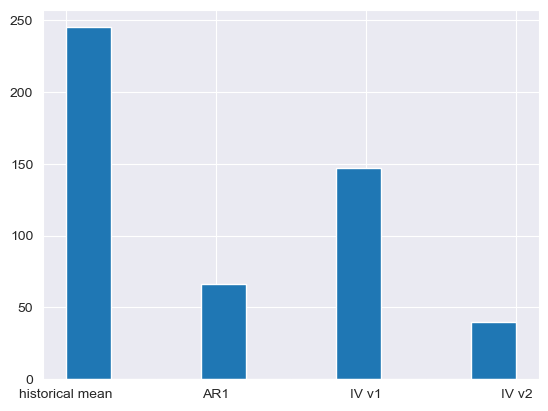

In [55]:
df_tickers_copy['Best performing model'].hist()

In [56]:
df_tickers_copy['sector'].value_counts()

sector
Technology                74
Industrials               72
Financial Services        66
Healthcare                64
Consumer Cyclical         58
Consumer Defensive        35
Real Estate               31
Utilities                 30
Energy                    23
Communication Services    22
Basic Materials           22
Name: count, dtype: int64

In [57]:
df_tickers_copy['industry'].value_counts()

industry
Utilities - Regulated Electric    23
Specialty Industrial Machinery    17
Semiconductors                    13
Software - Application            13
Diagnostics & Research            12
                                  ..
Electrical Equipment & Parts       1
Consumer Electronics               1
Copper                             1
Utilities - Regulated Water        1
Insurance - Reinsurance            1
Name: count, Length: 114, dtype: int64

<Axes: >

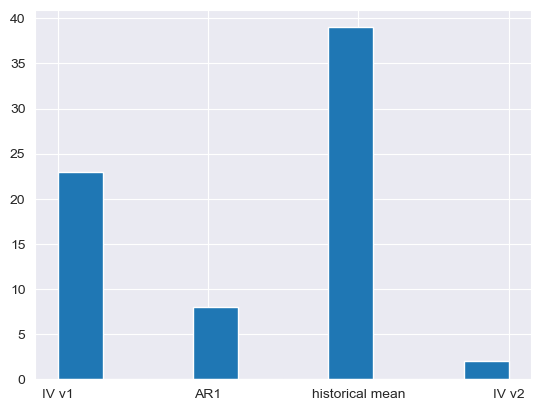

In [58]:
df_tickers_copy[df_tickers_copy['sector'] == 'Industrials']['Best performing model'].hist()

In [59]:
df_tickers_copy

,Unnamed: 0,Ticker,sector,sectorKey,industry,beta,marketCap,beta_calc,RMSE_vanilla,RMSE_historical_mean,RMSE_iv_v1,RMSE_iv_v2,Best performing model
0,0,SPY,NaN,NaN,NaN,NaN,NaN,1.000000,0.000529,0.000526,0.000528,0.000529,historical mean
1,1,MSFT,Technology,technology,Software - Infrastructure,0.890,3.094184e+12,0.945450,0.001041,0.001048,0.001055,0.001053,AR1
2,2,AAPL,Technology,technology,Consumer Electronics,1.289,2.665581e+12,1.101567,0.001499,0.001495,0.001484,0.001505,IV v1
3,3,NVDA,Technology,technology,Semiconductors,1.725,2.195913e+12,1.519579,0.003442,0.003438,0.003309,0.003934,IV v1
4,4,AMZN,Consumer Cyclical,consumer-cyclical,Internet Retail,1.171,1.811770e+12,1.081596,0.001824,0.001814,0.001809,0.001836,IV v1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,493,ZION,Financial Services,financial-services,Banks - Regional,1.117,5.872965e+09,1.525869,0.002727,0.002691,0.002587,0.002760,IV v1
494,494,MHK,Consumer Cyclical,consumer-cyclical,"Furnishings, Fixtures & Appliances",1.331,7.505347e+09,1.564907,0.003080,0.003065,0.003065,0.003268,historical mean
495,495,VFC,Consumer Cyclical,consumer-cyclical,Apparel Manufacturing,1.527,5.746700e+09,1.114432,0.001976,0.001997,0.002053,0.001970,IV v2
496,496,FOX,Communication Services,communication-services,Entertainment,0.794,1.340617e+10,1.283736,0.001961,0.001856,0.001309,0.002305,IV v1


In [60]:
df_tickers_copy_percentage = df_tickers_copy.groupby(by=['sector', 'Best performing model'])['Ticker'].count()/df_tickers_copy.groupby(by=['sector'])['Ticker'].count()
df_tickers_copy_percentage = pd.DataFrame(df_tickers_copy_percentage).rename(columns={'Ticker': 'Percentage of stocks in the industry'})
df_tickers_copy_percentage.head(7)

Percentage of stocks in the industry
sector                 Best performing model                                      
Basic Materials        AR1                                                0.136364
                       IV v1                                              0.318182
                       historical mean                                    0.545455
Communication Services AR1                                                0.090909
                       IV v1                                              0.545455
                       historical mean                                    0.363636
Consumer Cyclical      AR1                                                0.137931

In [61]:
df_tickers_copy_percentage.sort_values(['sector', 'Best performing model'])

Percentage of stocks in the industry
sector                 Best performing model                                      
Basic Materials        AR1                                                0.136364
                       IV v1                                              0.318182
                       historical mean                                    0.545455
Communication Services AR1                                                0.090909
                       IV v1                                              0.545455
                       historical mean                                    0.363636
Consumer Cyclical      AR1                                                0.137931
                       IV v1                                              0.327586
                       IV v2                                              0.051724
                       historical mean                                    0.482759
Consumer Defensive     AR1                                                0.142857
                       IV v1                                              0.114286
                       IV v2                                              0.314286
                       historical mean                                    0.428571
Energy                 AR1                                                0.217391
                       IV v1                                              0.086957
                       IV v2                                              0.086957
                       historical mean                                    0.608696
Financial Services     AR1                                                0.060606
                       IV v1                                              0.363636
                       IV v2                                              0.060606
                       historical mean                                    0.515152
Healthcare             AR1                                                0.203125
                       IV v1                                              0.234375
                       IV v2                                              0.062500
                       historical mean                                    0.500000
Industrials            AR1                                                0.111111
                       IV v1                                              0.319444
                       IV v2                                              0.027778
                       historical mean                                    0.541667
Real Estate            AR1                                                0.225806
                       IV v1                                              0.387097
                       IV v2                                              0.096774
                       historical mean                                    0.290323
Technology             AR1                                                0.121622
                       IV v1                                              0.378378
                       IV v2                                              0.027027
                       historical mean                                    0.472973
Utilities              AR1                                                0.066667
                       IV v1                                              0.033333
                       IV v2                                              0.300000
                       historical mean                                    0.600000

<Axes: xlabel='Best performing model', ylabel='Percentage of stocks in the industry'>

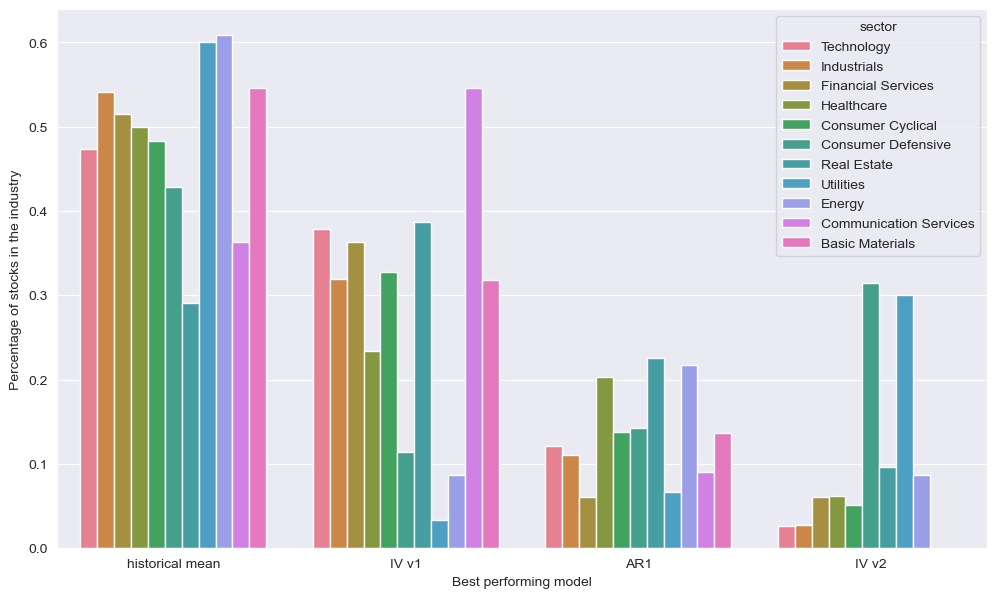

In [62]:
plt.figure(figsize=(12, 7))
sns.barplot(df_tickers_copy_percentage, x='Best performing model', y='Percentage of stocks in the industry', hue='sector', order=list(df_tickers_copy['Best performing model'].value_counts().index)
, hue_order=list(df_tickers_copy['sector'].value_counts().index
))

In [ ]:
calculate for diff industries the significance of the performance betweeen models (any significant differencies?)

<Axes: xlabel='Best performing model', ylabel='percent'>

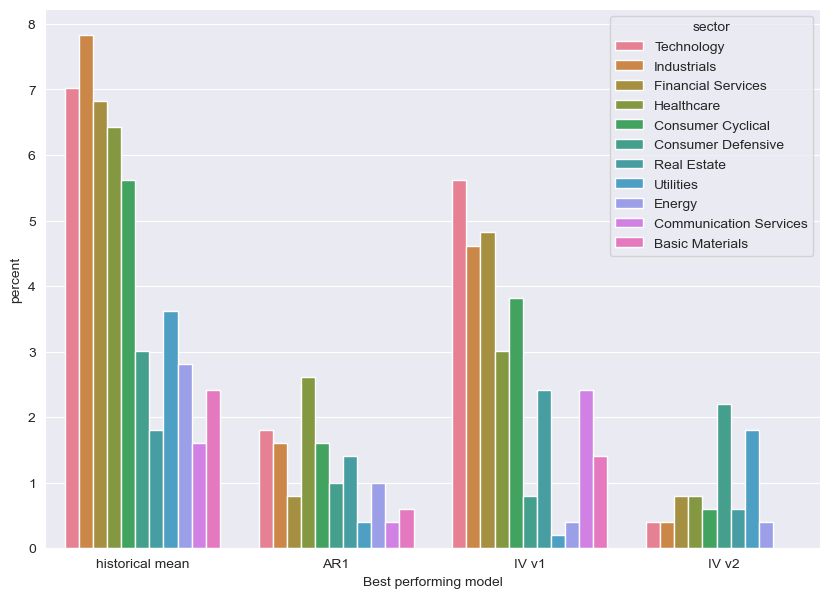

In [16]:
plt.figure(figsize=(10, 7))
sns.countplot(data=df_tickers_copy, x="Best performing model", hue="sector", hue_order=list(df_tickers_copy['sector'].value_counts().index
), stat='percent')

In [59]:
import seaborn as sns
print(sns.__version__)

0.12.2


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/envs/financialproject3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_18542/4058345069.py", line 2, in <module>
    sns.countplot(data=df_tickers_copy, x="Best performing model", hue="beta")
  File "/opt/anaconda3/envs/financialproject3/lib/python3.11/site-packages/seaborn/categorical.py", line 2955, in countplot
    inner_kws = plot_kws.pop("inner_kws", {}).copy()
    ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/financialproject3/lib/python3.11/site-packages/seaborn/categorical.py", line 1587, in plot
  File "/opt/anaconda3/envs/financialproject3/lib/python3.11/site-packages/seaborn/categorical.py", line 767, in annotate_axes
    iter_vars = [self.orient, "hue"]
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/financialproject3/lib/python3.11/si

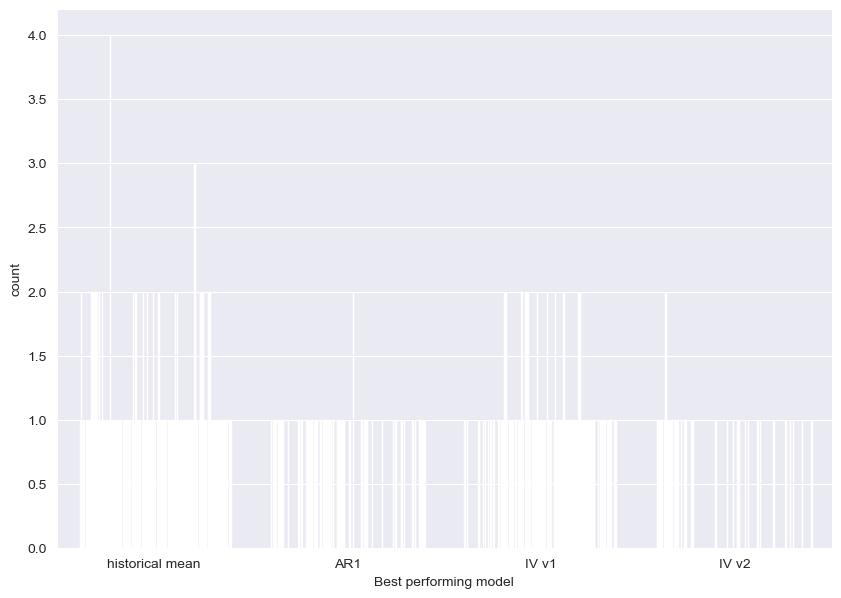

In [60]:
plt.figure(figsize=(10, 7))
sns.countplot(data=df_tickers_copy, x="Best performing model", hue="beta")

In [61]:
df_tickers_copy[['MSE_vanilla', 'MSE_historical_mean', 'MSE_iv_v1', 'MSE_iv_v2']].mean(axis=0)

MSE_vanilla            0.001967
MSE_historical_mean    0.001942
MSE_iv_v1              0.001967
MSE_iv_v2              0.002006
dtype: float64

In [62]:
# def diff_lists(list1, list2):
#     if len(list1) == len(list2):
#         res = [np.NaN]*len(list1)
#         for i in range(0, len(list1)):
#             res[i] = list1[i] - list2[i]
#         return res
#     else:
#         print('diff_lists function: Different lengths Warning')
#         l = min(len(list1), len(list2))
#         d = abs(len(list2) - len(list1))
#         if len(list1) < len(list2):
#             list1 = [np.NaN]*d + list1
#         else:
#             list2 = [np.NaN]*d + list2
#         res = [np.NaN]*min(len(list1), len(list2))
#         for i in range(0, len(list1)):
#             res[i] = list1[i] - list2[i]
#         return res

def diff_errors_dataframes(df1, df2):
    df3 = df1.join(df2.set_index('Date'), on='Date', how='outer', rsuffix='_r')
    df3['Diff'] = df3['Error'] - df3['Error_r']
    return df3[['Date', 'Diff']].dropna()
        
        
        
def plot_errors(result_meta_stocks, model1_name, model2_name, ticker):
    errors_vanilla = result_meta_stocks[model1_name]['errors'][ticker]
    errors_iv = result_meta_stocks[model2_name]['errors'][ticker]
    # print(errors_vanilla)
    # print('\n\n\n\n\n\n\n\n\n\n', errors_iv)
    # print(len(errors_vanilla), len(errors_iv))
    
    fig, ax = plt.subplots(3, 1, figsize=(15, 6))
    ax[0].plot(errors_vanilla['Date'], errors_vanilla['Error'])
    ax[1].plot(errors_iv['Date'], errors_iv['Error'])
    df_diff = diff_errors_dataframes(errors_vanilla, errors_iv)
    ax[2].plot(df_diff['Date'], df_diff['Diff']) # difference of errors with time
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].hist(errors_vanilla['Error'], bins=15)
    ax[1].hist(errors_iv['Error'].to_list(), bins=15)
    
    fig = sm.qqplot(np.array(errors_iv['Error']), fit=True, line='45')
    
    plt.show()
    
    print("Shapiro-Wilk test for vanilla and iv residuals normality:\nReg: ", shapiro(errors_vanilla['Error'].to_list()), "\nIV: ", shapiro(errors_iv['Error'].to_list()))
    print("\nt-test for residual means: ", scipy.stats.ttest_ind(errors_vanilla['Error'].to_list(), errors_iv['Error'].to_list(), equal_var = False))
    
# def errors_statistic(result_meta_stocks, ticker):

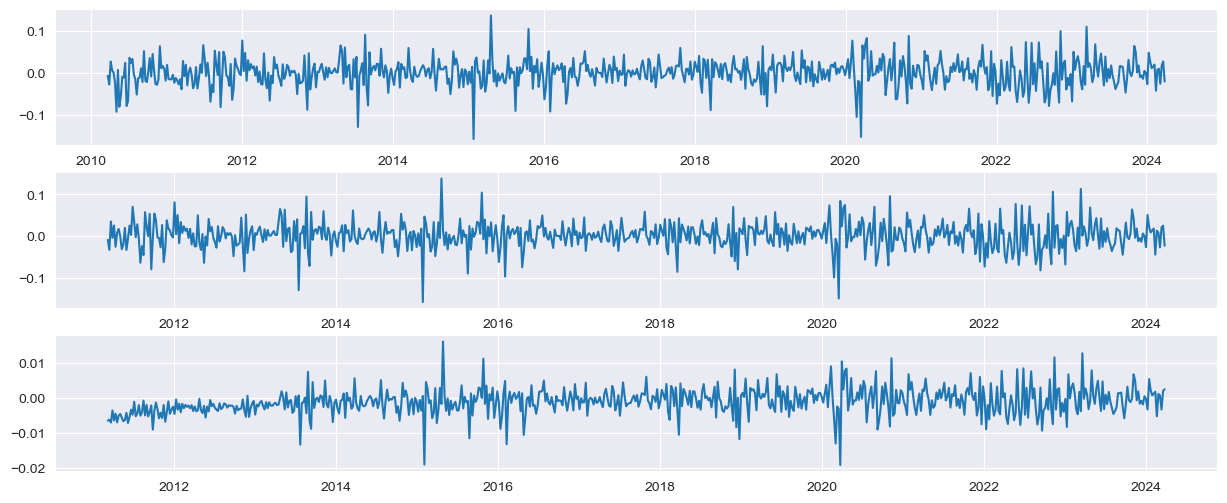

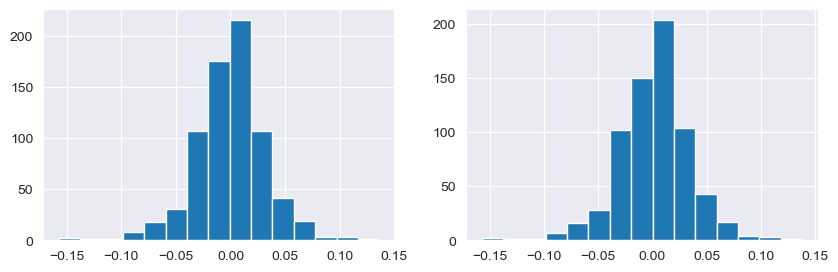

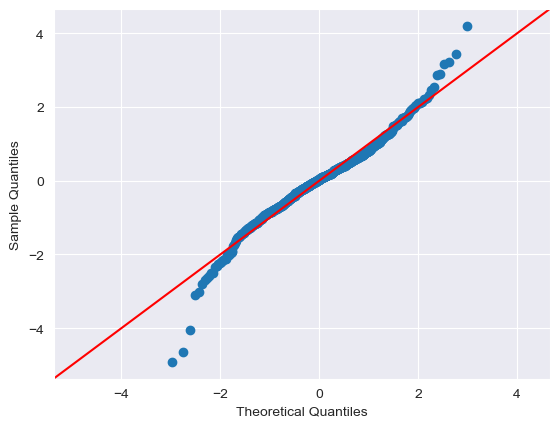

Shapiro-Wilk test for vanilla and iv residuals normality:
Reg:  ShapiroResult(statistic=0.973079486228305, pvalue=2.350432986416808e-10) 
IV:  ShapiroResult(statistic=0.971580341947963, pvalue=3.0946034916101117e-10)

t-test for residual means:  TtestResult(statistic=-0.9971981074532598, pvalue=0.3188401930518366, df=1403.9679112349918)


In [63]:
plot_errors(result_meta_stocks, model1_name='vanilla', model2_name='iv_pred_v1', ticker='MSFT')

In [64]:
significance = 0.05 # loop to find tickers with significant difference in errors in vanilla vs v1
tickers_with_significant_difference_in_errors = []
for ticker in tickers:
    if ticker == "SPY":
        continue
    if scipy.stats.ttest_ind(result_meta_stocks['vanilla']['errors'][ticker]['Error'].to_list(), result_meta_stocks['iv_pred_v1']['errors'][ticker]['Error'].to_list(), equal_var = False)[1] < significance: # False - Welch’s t-test, does not assume equal population variance
        tickers_with_significant_difference_in_errors.append(ticker)
print(tickers_with_significant_difference_in_errors)

['TMUS', 'CARR', 'AVB', 'FITB', 'EQR', 'LVS', 'HBAN', 'INCY']


In [65]:
significance = 0.05 # loop to find tickers with significant difference in errors in vanilla vs v2
tickers_with_significant_difference_in_errors = []
for ticker in tickers:
    if ticker == "SPY":
        continue
    if scipy.stats.ttest_ind(result_meta_stocks['vanilla']['errors'][ticker]['Error'].to_list(), result_meta_stocks['iv_pred_v2']['errors'][ticker]['Error'].to_list(), equal_var = False)[1] < significance: # False - Welch’s t-test, does not assume equal population variance
        tickers_with_significant_difference_in_errors.append(ticker)
print(tickers_with_significant_difference_in_errors)

[]


(array([187., 167.,  73.,  31.,  18.,  10.,   6.,   0.,   2.,   1.,   0.,
          0.,   0.,   2.,   1.]),
 array([0.00049651, 0.0013586 , 0.0022207 , 0.0030828 , 0.0039449 ,
        0.00480699, 0.00566909, 0.00653119, 0.00739328, 0.00825538,
        0.00911748, 0.00997957, 0.01084167, 0.01170377, 0.01256586,
        0.01342796]),
 <BarContainer object of 15 artists>)

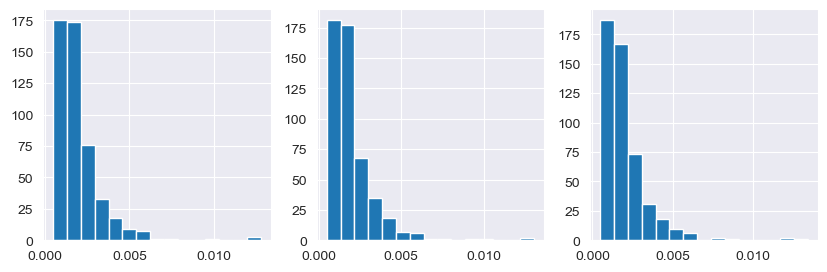

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].hist(list(result_meta_stocks['vanilla']['MSE'].values()), bins=15)
ax[1].hist(list(result_meta_stocks['iv_pred_v1']['MSE'].values()), bins=15)
ax[2].hist(list(result_meta_stocks['iv_pred_v2']['MSE'].values()), bins=15)

In [256]:
print('MSE mean average for AR1: ', np.mean(list(result_meta_stocks['vanilla']['MSE'].values())))
print('MSE mean average for AR1 IV v1: ', np.mean(list(result_meta_stocks['iv_pred_v1']['MSE'].values())))
print('MSE mean average for AR1 IV v2: ', np.mean(list(result_meta_stocks['iv_pred_v2']['MSE'].values())))

MSE mean average for AR1:  0.001959163930090851
MSE mean average for AR1 IV v1:  0.0019642835898102734
MSE mean average for AR1 IV v2:  0.0019923393810936836


In [67]:
print('MSE mean average for AR1: ', np.mean(list(result_meta_stocks['vanilla']['MSE'].values())))
print('MSE mean average for AR1 IV v1: ', np.mean(list(result_meta_stocks['iv_pred_v1']['MSE'].values())))
print('MSE mean average for AR1 IV v2: ', np.mean(list(result_meta_stocks['iv_pred_v2']['MSE'].values())))

MSE mean average for AR1:  0.0019667894210338675
MSE mean average for AR1 IV v1:  0.001966980774801377
MSE mean average for AR1 IV v2:  0.002006403122862559


In [70]:
print(stats.mannwhitneyu(list(result_meta_stocks['vanilla']['MSE'].values()), list(result_meta_stocks['iv_pred_v1']['MSE'].values())))
print(stats.mannwhitneyu(list(result_meta_stocks['vanilla']['MSE'].values()), list(result_meta_stocks['iv_pred_v2']['MSE'].values())))

MannwhitneyuResult(statistic=123723.0, pvalue=0.9510777339171048)
MannwhitneyuResult(statistic=122241.5, pvalue=0.698217857739258)


### Save Everything

In [71]:
with open('result_meta_stocks.pkl', 'wb') as f:
    pickle.dump(result_meta_stocks, f)

df_tickers_copy.to_csv("df_tickers_copy.csv")
data.to_csv("data.csv")

### Futures, Currencies

In [240]:
df_AD = pd.read_csv('data/AD_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "AD"})
df_BP = pd.read_csv('data/BP_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "BP"})
df_CD = pd.read_csv('data/CD_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "CD"})
df_JY = pd.read_csv('data/JY_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "JY"})
df_SF = pd.read_csv('data/SF_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "SF"})
df_CL = pd.read_csv('data/CL_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "CL"})
df_NG = pd.read_csv('data/NG_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "NG"})
df_GC = pd.read_csv('data/GC_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "GC"})
df_SI = pd.read_csv('data/SI_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "SI"})
df_ES = pd.read_csv('data/ES_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "ES"})

In [241]:
df_AD['Date'] = pd.to_datetime(df_AD['Date'])
df_BP['Date'] = pd.to_datetime(df_BP['Date'])
df_CD['Date'] = pd.to_datetime(df_CD['Date'])
df_JY['Date'] = pd.to_datetime(df_JY['Date'])
df_SF['Date'] = pd.to_datetime(df_SF['Date'])
df_CL['Date'] = pd.to_datetime(df_CL['Date'])
df_NG['Date'] = pd.to_datetime(df_NG['Date'])
df_GC['Date'] = pd.to_datetime(df_GC['Date'])
df_SI['Date'] = pd.to_datetime(df_SI['Date'])
df_ES['Date'] = pd.to_datetime(df_ES['Date'])

In [242]:
df_AD.head()

,Date,AD
0,1995-08-11,0.3685
1,1995-08-14,0.3685
2,1995-08-15,0.3685
3,1995-08-16,0.3685
4,1995-08-17,0.3685


In [243]:
print(df_AD.dtypes)

Date    datetime64[ns]
AD             float64
dtype: object


In [244]:
tickers_fc = ['AD', 'BP', 'CD', 'JY', 'SF', 'CL', 'NG', 'GC', 'SI', 'ES']

In [245]:
df_AD = df_AD.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_BP = df_BP.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_CD = df_CD.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_JY = df_JY.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_SF = df_SF.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_CL = df_CL.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_NG = df_NG.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_GC = df_GC.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_SI = df_SI.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_ES = df_ES.groupby(pd.Grouper(key="Date", freq="1W")).last()

In [246]:
df_fc = pd.merge(df_AD, df_BP, on='Date', how='outer').merge(df_CD, on='Date', how='outer').merge(df_JY, on='Date', how='outer').merge(df_SF, on='Date', how='outer').merge(df_CL, on='Date', how='outer').merge(df_NG, on='Date', how='outer').merge(df_GC, on='Date', how='outer').merge(df_SI, on='Date', how='outer').merge(df_ES, on='Date', how='outer')


In [247]:
df_fc = df_fc.reset_index()
df_fc.head()

,Date,AD,BP,CD,JY,SF,CL,NG,GC,SI,ES
0,1995-08-13,0.3685,1.3941,0.7362,0.017432,1.32805,69.02,28.784,688.6,15.345,NaN
1,1995-08-20,0.3685,1.3365,0.7398,0.016932,1.30815,68.94,28.858,689.2,15.827,NaN
2,1995-08-27,0.3792,1.3359,0.7481,0.016932,1.31495,69.29,28.906,687.1,15.722,NaN
3,1995-09-03,0.3920,1.3489,0.7511,0.016832,1.32505,69.47,28.952,684.0,15.402,NaN
4,1995-09-10,0.3920,1.3415,0.7515,0.016632,1.31275,69.87,28.854,684.9,15.455,NaN


In [248]:
df_fc = df_fc.loc[df_fc['Date'].dt.date > (datetime.datetime.now() - relativedelta(years=15)).date()]
df_fc.head()

,Date,AD,BP,CD,JY,SF,CL,NG,GC,SI,ES
712,2009-04-05,0.5213,1.5349,0.7953,0.011740,1.13475,95.69,15.595,1196.6,18.689,822.50
713,2009-04-12,0.5216,1.5156,0.7967,0.011719,1.11445,95.42,15.404,1182.6,18.284,834.50
714,2009-04-19,0.5242,1.5315,0.8054,0.011843,1.10695,93.47,15.523,1167.2,17.744,848.75
715,2009-04-26,0.5272,1.5193,0.8100,0.012067,1.12805,92.55,15.089,1213.4,18.874,848.50
716,2009-05-03,0.5358,1.5446,0.8269,0.011824,1.13105,94.20,15.233,1187.5,18.428,858.00


In [249]:
df_fc[['Return ' + ticker for ticker in tickers_fc]] = np.log(df_fc[tickers_fc]).diff()

In [250]:
df_fc = df_fc.drop(columns=tickers_fc)

In [251]:
df_fc.isna().sum()

Date         0
Return AD    1
Return BP    1
Return CD    1
Return JY    1
Return SF    1
Return CL    1
Return NG    1
Return GC    1
Return SI    1
Return ES    1
dtype: int64

In [252]:
df_fc = df_fc.dropna()
df_fc = df_fc.reset_index().drop(columns='index')
df_fc.head()

,Date,Return AD,Return BP,Return CD,Return JY,Return SF,Return CL,Return NG,Return GC,Return SI,Return ES
0,2009-04-12,0.000575,-0.012654,0.001759,-0.001790,-0.018051,-0.002826,-0.012323,-0.011769,-0.021909,0.014484
1,2009-04-19,0.004972,0.010436,0.010861,0.010526,-0.006753,-0.020648,0.007696,-0.013108,-0.029979,0.016932
2,2009-04-26,0.005707,-0.007998,0.005695,0.018737,0.018882,-0.009891,-0.028357,0.038819,0.061738,-0.000295
3,2009-05-03,0.016181,0.016515,0.020650,-0.020343,0.002656,0.017671,0.009498,-0.021576,-0.023914,0.011134
4,2009-05-10,0.070435,0.018792,0.028141,0.008338,0.019784,0.056043,0.049000,0.022235,0.075994,0.055263


In [257]:
%%time
result_meta_fc = {}
for step in ['vanilla', 'iv_train']:
    print(step)
    result_meta_fc[step] = instrumental_variables(df_fc, tickers_fc, step=step, iv_column_name='Return ES')
print('iv_pred_v1')
result_meta_fc['iv_pred_v1'] = instrumental_variables(df_fc, tickers_fc, step='iv_pred_v1', iv_column_name='Return ES')
print('iv_pred_v2')
result_meta_fc['iv_pred_v2'] = instrumental_variables(df_fc, tickers_fc, step='iv_pred_v2', iv_column_name='Return ES', coefficients_iv_train=result_meta_fc['iv_train']['coefficients'])

vanilla


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


iv_train


100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


iv_pred_v1


100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


iv_pred_v2


100%|██████████| 10/10 [00:23<00:00,  2.37s/it]

CPU times: user 1min 35s, sys: 1.03 s, total: 1min 36s
Wall time: 1min 37s


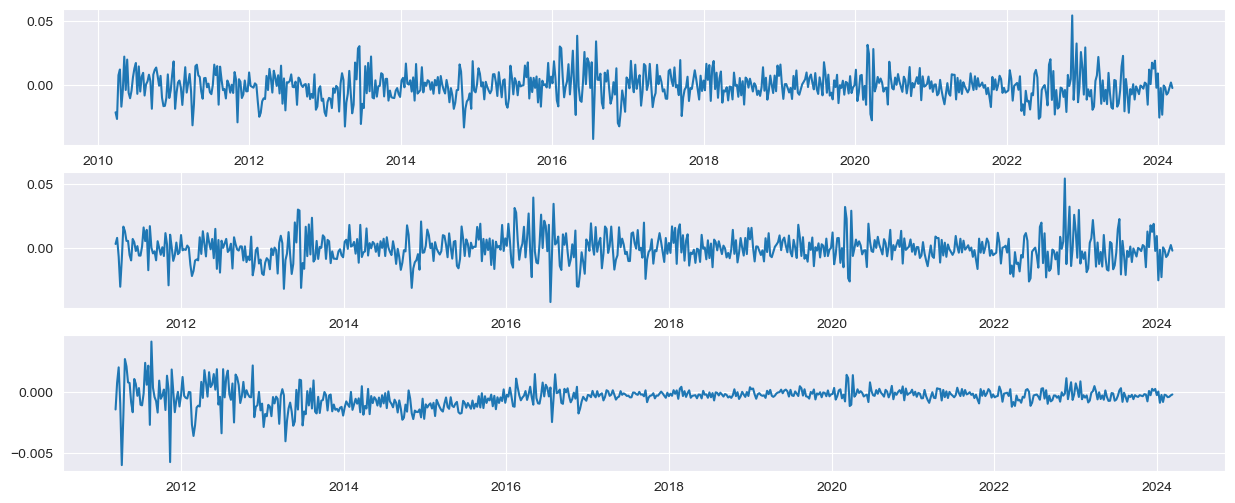

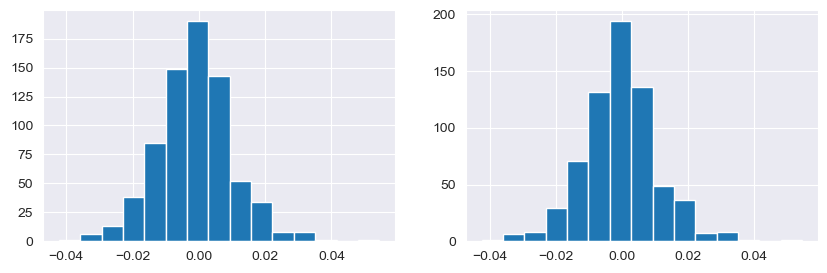

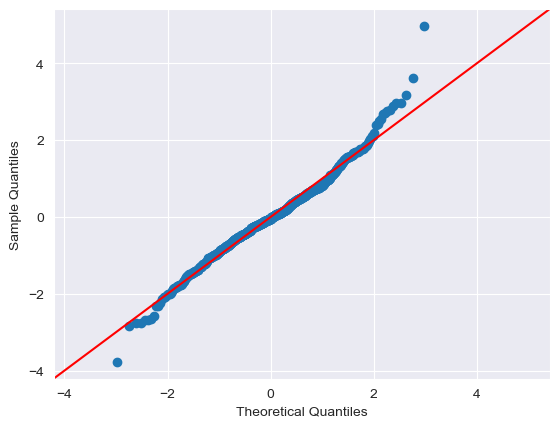

Shapiro-Wilk test for vanilla and iv residuals normality:
Reg:  ShapiroResult(statistic=0.9879332184791565, pvalue=1.0337113053537905e-05) 
IV:  ShapiroResult(statistic=0.9841092228889465, pvalue=9.767053370524081e-07)

t-test for residual means:  TtestResult(statistic=-0.5317444983727095, pvalue=0.5949873182742028, df=1400.200300462929)


In [260]:
plot_errors(result_meta_fc, model1_name='vanilla', model2_name='iv_pred_v1', ticker='JY')

In [261]:
print('MSE mean average for AR1: ', np.mean(list(result_meta_fc['vanilla']['MSE'].values())))
print('MSE mean average for AR1 IV v1: ', np.mean(list(result_meta_fc['iv_pred_v1']['MSE'].values())))
print('MSE mean average for AR1 IV v2: ', np.mean(list(result_meta_fc['iv_pred_v2']['MSE'].values())))

MSE mean average for AR1:  0.020328200565640824
MSE mean average for AR1 IV v1:  0.008489931998532301
MSE mean average for AR1 IV v2:  0.007470767297849882


In [266]:
significance = 0.05 # loop to find tickers with significant difference
tickers_with_significant_difference_in_errors_fc_iv_v1 = []
for ticker in tickers_fc:
    if ticker == "ES":
        continue
    if scipy.stats.ttest_ind(result_meta_fc['vanilla']['errors'][ticker]['Error'].to_list(), result_meta_fc['iv_pred_v1']['errors'][ticker]['Error'].to_list(), equal_var = False)[1] < significance: # False - Welch’s t-test, does not assume equal population variance
        tickers_with_significant_difference_in_errors_fc_iv_v1.append(ticker)
print(tickers_with_significant_difference_in_errors_fc_iv_v1)

['AD']


In [267]:
significance = 0.05 # loop to find tickers with significant difference
tickers_with_significant_difference_in_errors_fc_iv_v2 = []
for ticker in tickers_fc:
    if ticker == "ES":
        continue
    if scipy.stats.ttest_ind(result_meta_fc['vanilla']['errors'][ticker]['Error'].to_list(), result_meta_fc['iv_pred_v2']['errors'][ticker]['Error'].to_list(), equal_var = False)[1] < significance: # False - Welch’s t-test, does not assume equal population variance
        tickers_with_significant_difference_in_errors_fc_iv_v2.append(ticker)
print(tickers_with_significant_difference_in_errors_fc_iv_v2)

[]


In [268]:
print(stats.mannwhitneyu(list(result_meta_fc['vanilla']['MSE'].values()), list(result_meta_fc['iv_pred_v1']['MSE'].values())))
print(stats.mannwhitneyu(list(result_meta_fc['vanilla']['MSE'].values()), list(result_meta_fc['iv_pred_v2']['MSE'].values())))

MannwhitneyuResult(statistic=51.0, pvalue=0.9698499769931556)
MannwhitneyuResult(statistic=51.5, pvalue=0.9397203669477441)


In [273]:
df_mse = pd.DataFrame.from_dict(result_meta_fc['vanilla']['MSE'], orient='index', columns=['MSE_vanilla'])
df_mse = df_mse.join(pd.DataFrame.from_dict(result_meta_fc['vanilla']['MSE_historical_mean'], orient='index', columns=['MSE_historical_mean']))
df_mse = df_mse.join(pd.DataFrame.from_dict(result_meta_fc['iv_pred_v1']['MSE'], orient='index', columns=['MSE_iv_v1']))
df_mse = df_mse.join(pd.DataFrame.from_dict(result_meta_fc['iv_pred_v2']['MSE'], orient='index', columns=['MSE_iv_v2']))
df_mse.head()

,MSE_vanilla,MSE_historical_mean,MSE_iv_v1,MSE_iv_v2
AD,0.000266,0.000266,0.000236,0.000266
BP,0.000147,0.000146,0.000147,0.000147
CD,0.000111,0.000110,0.000105,0.000110
JY,0.000126,0.000124,0.000124,0.000124
SF,0.000155,0.000155,0.000158,0.000156


In [274]:
df_mse['Best Performing model'] = df_mse[['MSE_vanilla', 'MSE_historical_mean', 'MSE_iv_v1', 'MSE_iv_v2']].apply(lambda x: 'AR1' if x[0] < x[1] and x[0] < x[2] and x[0] < x[3] else 'historical mean' if x[1] < x[0] and x[1] < x[2] and x[1] < x[3] else 'IV v1' if x[2] < x[0] and x[2] < x[1] and x[2] < x[3] else 'IV v2', axis=1)

<Axes: xlabel='Best Performing model', ylabel='Count'>

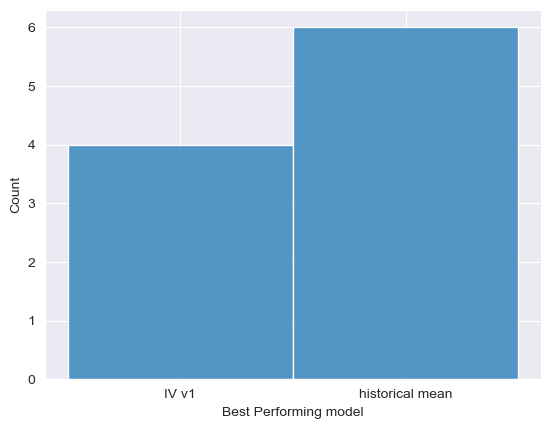

In [275]:
sns.histplot(df_mse['Best Performing model'])

In [276]:
df_mse.mean(axis=0)

/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_96467/1685114325.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_mse.mean(axis=0)


MSE_vanilla            0.020328
MSE_historical_mean    0.007414
MSE_iv_v1              0.008490
MSE_iv_v2              0.007471
dtype: float64

In [ ]:
# MSE of historical mean forecast
# for how many stocks outperform
# what fraction of the stocks have MSE lower that the market - ?
# for each stock, what is the best performing model from the 3 models (mean is the last one)? 
# do the analysis for the commodities, bonds, futures, too
# wrap this up for a paper 1-2 pages

# use the same X with IV coefficient
# look at the pattern with more data
# commodities and currencies back adjusted price google (roll)

# I need more data to try to do more analysis - betas (estimate betas), Market Cap
# template of a paper

# why do we predict using betas with the initial Returns
# what are we trying to find?
# shouldn't the IV's performance be worse in general? The method is used in obtaining more consistent and unbiased results
# should I do tests for AR, heteroskedasticity, etc? (Durbin-Watson, Shapiro-Wilk)


# verify with just using SPY instead of 2SLS
# what drives the IV model to underperform? (fitted with the plot MSE)
# plot the average AR and IV coefficients (the last one)
# why MSE for fc seem to be significant, but the MannWhitney test doesn't work
# compute root MSE
# unit root problems?


I just wanted to know if you received everything for my application to be completed. Could you approximately tell me how long does the review process take?  